# White Dwarf Operating Conditions

In [3]:
#Import required modules
import bamboo as bam
import bamboo.cooling as cool
import bamboo.materials


import numpy as np
import matplotlib.pyplot as plt
import pypropep as ppp
import bamboo.plot
from CoolProp.CoolProp import PropsSI

### *Engine setup*

In [25]:
'''Chamber conditions'''
pc = 10e5                   #Chamber pressure (Pa)
thrust = 1.5e3              #Desired thrust (N)
p_amb = 1.01325e5           #Ambient pressure (Pa). 1.01325e5 is sea level atmospheric.
OF_ratio = 3.5              #Oxidiser/fuel mass ratio
water_mass_fraction = 0.40  #Fraction of the fuel that is water, by mass

'''Get combustion properties from pypropep - we'll investigate both equilibrium and frozen flow'''
ppp.init()
p_froz = ppp.FrozenPerformance()
p_shift = ppp.ShiftingPerformance()

ipa = ppp.PROPELLANTS['ISOPROPYL ALCOHOL']
water = ppp.PROPELLANTS['WATER']
n2o = ppp.PROPELLANTS['NITROUS OXIDE']

#Add propellants by mass fractions (note the mass fractions can add up to more than 1)
p_froz.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])
p_shift.add_propellants_by_mass([(ipa, 1-water_mass_fraction), (water, water_mass_fraction), (n2o, OF_ratio)])
                  
p_froz.set_state(P = pc/1e5, Pe = p_amb/1e5)                      
p_shift.set_state(P = pc/1e5, Pe = p_amb/1e5)                      

gamma = p_froz.properties[0].Isex   #Index 0 means chamber conditions. pyrpopep uses 'Isex' for the ratio of specific heats
cp = 1000*p_froz.properties[0].Cp   #Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T

isp_froz = p_froz.performance.Isp
isp_shift = p_shift.performance.Isp

mdot = thrust/isp_froz        #We'll use frozen flow isp to choose the mass flow rate

'''Set up the engine object'''
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)    #Gas for frozen flow
chamber_conditions = bam.ChamberConditions(pc, Tc, mdot)
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber_conditions, p_amb, type = "rao")
engine = bam.Engine(perfect_gas, chamber_conditions, nozzle)

'''Chamber and wall geometry'''
Ac = np.pi*0.06**2                      #Chamber cross-sectional area (m^2)
L_star = 1.2                           #L_star = Volume_c/Area_t
chamber_length = L_star*nozzle.At/Ac   #Length of the combustion chamber
engine.add_geometry(chamber_length = chamber_length,
                    chamber_area = Ac,
                    inner_wall_thickness = 2e-3,
                    outer_wall_thickness = 2e-3)


Loaded 1921 thermo species
Loaded 1031 propellants
NOTE: Area ratio is outside of data range for Rao bell nozzle graphs (minimum 3.7, maximum 47). Using a 15 deg cone nozzle instead.


### Engine performance

In [58]:
print(f"""
Mass flow rate = {mdot:.3f} kg/s

Sea level thrust     = {engine.thrust(1e5)/1000:.3f} kN      (perfect gas relations)
Sea level thrust     = {isp_froz * mdot/1000:.3f} kN      (frozen flow - PyProPEP)
Sea level thrust     = {isp_shift * mdot/1000:.3f} kN      (equilibrium flow - PyProPEP)

Sea level Isp        = {engine.isp(1e5):.3f} s     (perfect gas relations)
Sea level thrust     = {isp_froz/9.80665:.3f} s     (frozen flow - PyProPEP)
Sea level Isp        = {isp_shift/9.80665:.3f} s     (equilibrium flow - PyProPEP)

Chamber Temperature  = {Tc:.3f} K
Gamma                = {gamma:.3f}
cp                   = {cp:.3f} J/kg/K
""")

print("\nCombustion product composition:")
print(p.composition['chamber'][0:8])



Mass flow rate = 0.803 kg/s

Sea level thrust     = 1.914 kN      (perfect gas relations)
Sea level thrust     = 1.500 kN      (frozen flow - PyProPEP)
Sea level thrust     = 1.546 kN      (equilibrium flow - PyProPEP)

Sea level Isp        = 242.923 s     (perfect gas relations)
Sea level thrust     = 190.398 s     (frozen flow - PyProPEP)
Sea level Isp        = 196.176 s     (equilibrium flow - PyProPEP)

Chamber Temperature  = 2868.057 K
Gamma                = 1.140
cp                   = 4014.403 J/kg/K


Combustion product composition:
[('N2', 0.44747502468273587), ('H2O', 0.31267294528360934), ('CO2', 0.10401242950642305), ('CO', 0.06577575833473565), ('H2', 0.02777714200293597), ('OH', 0.018156065813505123), ('O2', 0.009885745316190067), ('NO', 0.006600861607412714)]


### Geometry

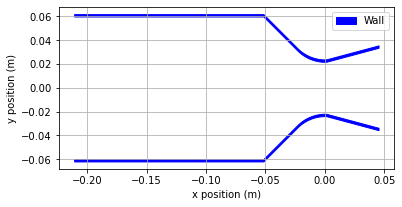


Chamber length       = 0.15926 m
Nozzle length (total)= 0.09693 m

Throat area         = 0.00150 m^2  (Bamboo - perfect gas)
Throat area         = 0.00117 m^2  (PyProPEP - frozen flow)
Throat area         = 0.00120 m^2  (PyProPEP - equilibrium flow)

Throat radius       = 21.9 mm  (Bamboo - perfect gas)
Throat radius       = 19.3 mm  (PyProPEP - frozen flow)
Throat radius       = 19.6 mm  (PyProPEP - equilibrium flow)

Exit area           = 0.00356 m^2  (Bamboo - perfect gas)
Exit area           = 0.00255 m^2  (frozen flow)
Exit area           = 0.00282 m^2  (frozen flow)

Exit radius         = 33.7 mm  (Bamboo - perfect gas)
Exit radius         = 28.5 mm  (PyProPEP - frozen flow)
Exit radius         = 29.9 mm  (PyProPEP - equilibrium flow)



In [65]:
engine.plot_geometry()
plt.show()

At_froz = p_froz._equil_structs[1].performance.a_dotm * mdot / 101325  # PyProPEP uses units of atm, need to convert to Pa
At_shift = p_shift._equil_structs[1].performance.a_dotm * mdot / 101325

Ae_froz = p_froz.performance.ae_at * At_froz
Ae_shift = p_shift.performance.ae_at * At_shift

print(f"""
Chamber length       = {chamber_length:.5f} m
Nozzle length (total)= {engine.geometry.x_max - engine.geometry.x_chamber_end:.5f} m

Throat area         = {nozzle.At:.5f} m^2  (Bamboo - perfect gas)
Throat area         = {At_froz:.5f} m^2  (PyProPEP - frozen flow)
Throat area         = {At_shift:.5f} m^2  (PyProPEP - equilibrium flow)

Throat radius       = {1e3*(nozzle.At/np.pi)**0.5:.1f} mm  (Bamboo - perfect gas)
Throat radius       = {1e3*(At_froz/np.pi)**0.5:.1f} mm  (PyProPEP - frozen flow)
Throat radius       = {1e3*(At_shift/np.pi)**0.5:.1f} mm  (PyProPEP - equilibrium flow)

Exit area           = {nozzle.Ae:.5f} m^2  (Bamboo - perfect gas)
Exit area           = {Ae_froz:.5f} m^2  (frozen flow)
Exit area           = {Ae_shift:.5f} m^2  (frozen flow)

Exit radius         = {1e3*(nozzle.Ae/np.pi)**0.5:.1f} mm  (Bamboo - perfect gas)
Exit radius         = {1e3*(Ae_froz/np.pi)**0.5:.1f} mm  (PyProPEP - frozen flow)
Exit radius         = {1e3*(Ae_shift/np.pi)**0.5:.1f} mm  (PyProPEP - equilibrium flow)
""")